## Jonathan C. Valencia
Maestria en ciencias computacionales

## Examen I
# Seccion II

In [148]:
import numpy as np
import pandas as pd
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import copy
from random import shuffle
import tqdm.notebook as tqdm
from PIL import Image
import sklearn
from sklearn.metrics import accuracy_score, cohen_kappa_score
from sklearn.metrics import classification_report
import cv2
import os
import shutil

Comienzo creando la clase CustomDataset para leer los datos, haciendo uso y aprovechando que las carpetas ya estan separadas por clases y validando imagenes y mascaras.

In [149]:
class CustomDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.samples = []  # List to store tuples of (image path, mask path, label)

        for class_name in os.listdir(data_dir):
            class_path = os.path.join(data_dir, class_name)
            if not os.path.isdir(class_path):
                continue  # Mac Os

            class_label = class_names.index(class_name) 

            images_dir = os.path.join(class_path, 'images')
            masks_dir = os.path.join(class_path, 'lung masks')

            image_files = os.listdir(images_dir)
            mask_files = os.listdir(masks_dir)

            # Make sure the number of images and masks are the same
            num_samples = min(len(image_files), len(mask_files))

            for i in range(num_samples):
                image_path = os.path.join(images_dir, image_files[i])
                mask_path = os.path.join(masks_dir, mask_files[i])
                self.samples.append((image_path, mask_path, class_label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_path, mask_path, label = self.samples[idx]

        # Open image and mask using PIL
        image = Image.open(image_path).convert('L')
        image = Image.merge('RGB', (image, image, image)) #debug
        mask = Image.open(mask_path).convert('L')

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, label, mask


Todo se corrio localmente en mi computadora:

In [150]:
train_path = '/Users/jonathanvalencia/Downloads/m3ex02-data/Train'
test_path = '/Users/jonathanvalencia/Downloads/m3ex02-data/Test'
val_path = '/Users/jonathanvalencia/Downloads/m3ex02-data/Val'


Defino los nombres de cada clase como se leen en las carpetas y algo muy importante para mi aqui es la visualizacion de los datos, ya que me ayuda a saber si los datos estan desbalanceados y tratar de balancearlos a traves del aumento de datos.

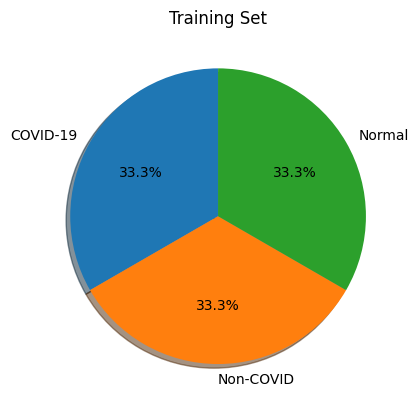

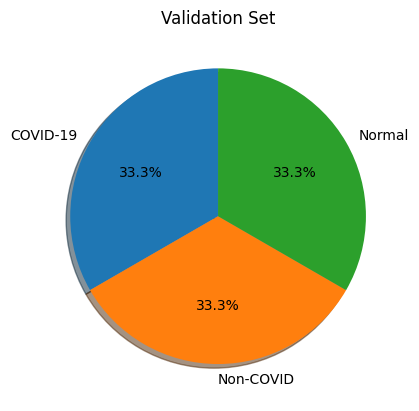

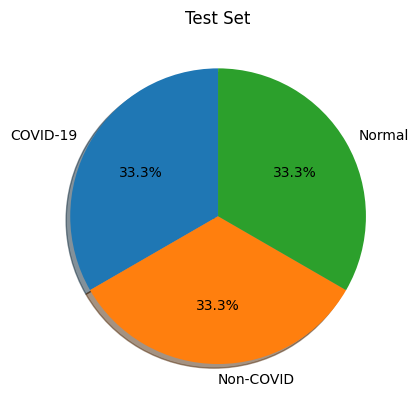

In [151]:
classes = 3
class_names = ['COVID-19', 'Non-COVID', 'Normal']

# Counting the number of images for each class in the training set
img_count_train = {class_names[i]: len(os.listdir(os.path.join(train_path, class_names[i]))) for i in range(classes)}

# Counting the number of images for each class in the validation set
img_count_val = {class_names[i]: len(os.listdir(os.path.join(val_path, class_names[i]))) for i in range(classes)}

# Counting the number of images for each class in the test set
img_count_test = {class_names[i]: len(os.listdir(os.path.join(test_path, class_names[i]))) for i in range(classes)}

# Plotting distribution of each class in the training set
fig1, ax1 = plt.subplots()
ax1.pie(img_count_train.values(),
        labels=img_count_train.keys(),
        shadow=True,
        autopct='%1.1f%%',
        startangle=90)
ax1.set_title('Training Set')
plt.show()

# Plotting distribution of each class in the validation set
fig2, ax2 = plt.subplots()
ax2.pie(img_count_val.values(),
        labels=img_count_val.keys(),
        shadow=True,
        autopct='%1.1f%%',
        startangle=90)
ax2.set_title('Validation Set')
plt.show()

# Plotting distribution of each class in the test set
fig3, ax3 = plt.subplots()
ax3.pie(img_count_test.values(),
        labels=img_count_test.keys(),
        shadow=True,
        autopct='%1.1f%%',
        startangle=90)
ax3.set_title('Test Set')
plt.show()


Afortunadamente los datos estan balanceados, algo que he leido de los conjuntos de imagenes medicas es que es muy comun encontrar datos desbalanceados lo cual puede terminar en overtfit, hay metodos como k-fold X validation para mitigar esto (los cuales gracias al cielo no tengo que emplear en estos momentos para este examen)

Para continuar con la visualizacion de datos, tomo un pequeno muestreo de cada una de las 3 clases y las imprimo. Y me doy cuenta de lo dificil que sera para el modelo alcanzar una precision alta, siendo que yo como humano apenas puedo distinguir cada uno, tal vez requiera mas de estudios medicos para poderlo hacer.

/var/folders/t7/8t2q6lz54qlclkq2sny7ptth0000gn/T/ipykernel_8923/3220731856.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


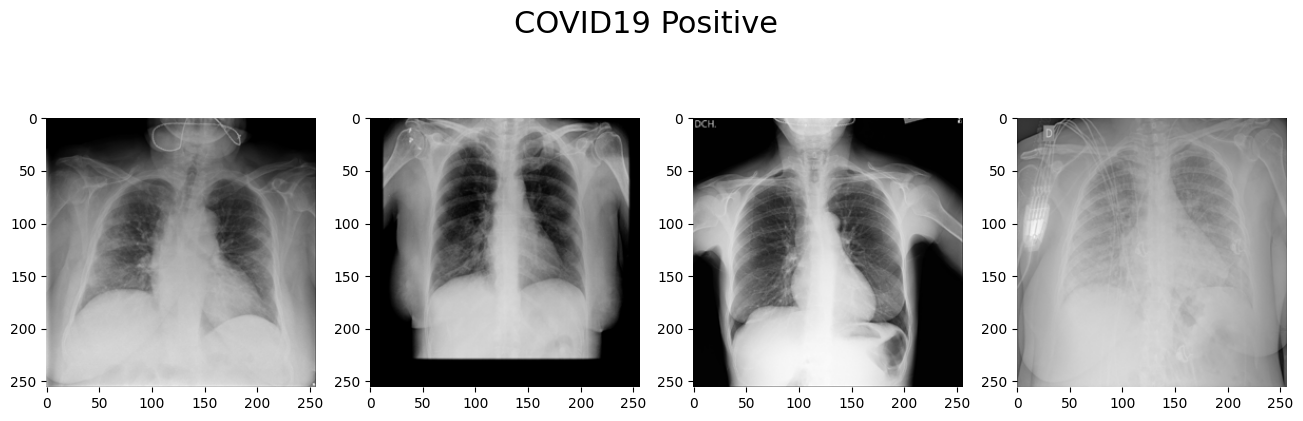

In [152]:
covid_train_path = "/Users/jonathanvalencia/Downloads/m3ex02-data/Train/COVID-19/images"
fig = plt.figure(figsize=(16,5))
fig.suptitle("COVID19 Positive", size=22)
img_paths = os.listdir(covid_train_path)
shuffle(img_paths)

for i,image in enumerate(img_paths[:4]):
    img = cv2.imread(os.path.join(covid_train_path, image))
    plt.subplot(1,4, i+1, frameon=False)
    plt.imshow(img)
fig.show()

/var/folders/t7/8t2q6lz54qlclkq2sny7ptth0000gn/T/ipykernel_8923/3635408295.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


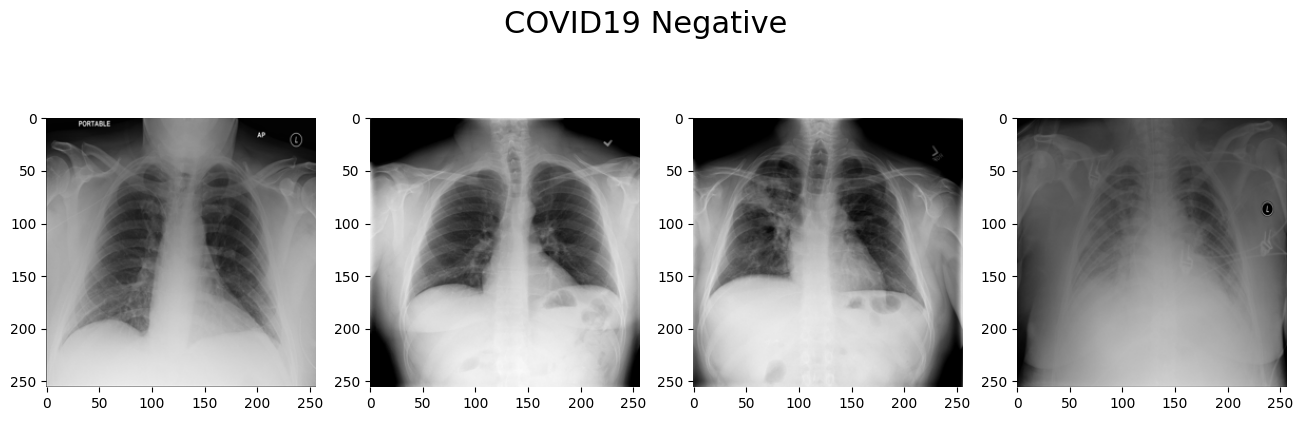

In [185]:
noncovid_train_path = "/Users/jonathanvalencia/Downloads/m3ex02-data/Train/Non-COVID/images"
fig = plt.figure(figsize=(16,5))
fig.suptitle("COVID19 Negative", size=22)
img_paths = os.listdir(noncovid_train_path)
shuffle(img_paths)

for i,image in enumerate(img_paths[:4]):
    img = cv2.imread(os.path.join(noncovid_train_path, image))
    plt.subplot(1,4, i+1, frameon=False)
    plt.imshow(img)
fig.show()

/var/folders/t7/8t2q6lz54qlclkq2sny7ptth0000gn/T/ipykernel_8923/2006312360.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


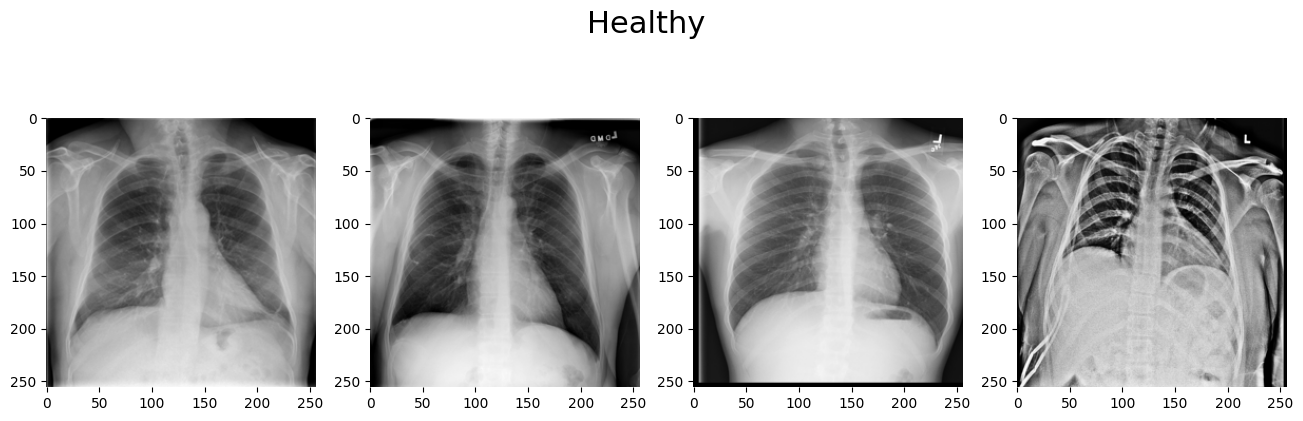

In [186]:
normal_train_path = "/Users/jonathanvalencia/Downloads/m3ex02-data/Train/Normal/images"
fig = plt.figure(figsize=(16,5))
fig.suptitle("Healthy", size=22)
img_paths = os.listdir(normal_train_path)
shuffle(img_paths)

for i,image in enumerate(img_paths[:4]):
    img = cv2.imread(os.path.join(normal_train_path, image))
    plt.subplot(1,4, i+1, frameon=False)
    plt.imshow(img)
fig.show()


La transformacion de datos, o data augmentation nos ayuda a generalizar el modelo para evitar overtfit, para este caso decidi ser conservador, aunque debo confensar que pase una buena parte del tiempo aqui y me di cuenta de algunas cosas, por ejemplo, no usar el flip horizontal o rotaciones por que hace un desastre con las radiografias, finalmente me decidi solo a reescalar la imagen y pasarla a tensor.


In [155]:
data_transforms = {
    "train": transforms.Compose([
        transforms.Resize((150, 150)),
        transforms.ToTensor()
    ]),
    "val": transforms.Compose([
        transforms.Resize((150, 150)),
        transforms.ToTensor()
    ])
}

In [156]:
# Create datasets
train_dataset = CustomDataset(train_path, transform=data_transforms['train'])
val_dataset = CustomDataset(val_path, transform=data_transforms['val'])

In [157]:
trainloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=128, shuffle=True)
dataloaders = {"train":trainloader, "val":valloader}

despues de definir los data loaders, hice un snip para poder revisar que mis dimensiones estuvieran correctas:

In [158]:
# Debugging
for inputs, classes, masks in trainloader:
    print("Input shape:", inputs.shape)  # Print the shape of the input images
    print("Classes:", classes)  # Print the classes/labels
    print("Mask shape:", masks.shape)  # Print the shape of the masks
    break  # Break after the first batch to avoid printing too many lines

Input shape: torch.Size([128, 3, 150, 150])
Classes: tensor([1, 2, 0, 1, 0, 0, 1, 0, 2, 1, 1, 0, 0, 1, 2, 2, 2, 0, 2, 0, 0, 1, 0, 1,
        1, 0, 2, 2, 1, 1, 1, 1, 0, 2, 0, 0, 0, 0, 2, 1, 2, 0, 1, 1, 1, 2, 2, 0,
        0, 0, 2, 2, 1, 2, 1, 0, 2, 0, 2, 0, 2, 2, 1, 2, 0, 1, 2, 0, 1, 0, 2, 1,
        1, 0, 0, 1, 2, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 2, 1, 1, 0, 1, 0, 0, 1,
        2, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 2, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
        2, 2, 1, 0, 1, 0, 0, 1])
Mask shape: torch.Size([128, 1, 150, 150])


In [159]:
data_loaders = {'train': trainloader, 'val': valloader}
data_sizes = {x: len(data_loaders[x].sampler) for x in ['train', 'val']}

Visualizacion del monton o batch para entrenar antes de proceder con el entrenamiento:

In [160]:
def imshow(inp, size =(30,30), title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=size)
    plt.imshow(inp)
    if title is not None:
        plt.title(title, size=30)
    plt.pause(0.001)  # Important: pause a bit so that plots are updated


# Get a batch of training data
inputs, classes, masks = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Para mi caso en particular, el entrenamiendo sera realizado en mi computadora, por lo cual debo entrenar en MPS, el GPU par Mac

In [161]:
torch.set_default_dtype(torch.float32)
if torch.backends.mps.is_available():
    device=torch.device("mps:0")
    print("Training on GPU... Ready for HyperJump...")
else:
    device = torch.device("cpu")
    print("Training on CPU... May the force be with you...")

Training on GPU... Ready for HyperJump...


In [162]:
torch.mps.empty_cache()

## Modelo

La parte mas importante de este examen es elegir el modelo adecuado, DenseNet-121 probablemente no es la primera opcion de muchos, sin embargo queria intentar algo diferente a los antes empleados en clase y los clasicos Resnet y UNet, para este examen use un modelo pre entrenado por que de otr forma nunga hubiese podido terminar, ademas de que funciona para hacer el Transfer Learning. Lo cual permite alcancar accuracy mas alto y entrenar mas rapido el modelo.

Transfer Learning es una tecnica importante, en la cual usamos parametros ya entrenados en un modelo mas grande como Imagenet.Un modelo pre entrenado ya tiene micro features y ese conocimiento nos ayuda a inicializar y darle un empujonn a nuestro modelo.
Esta es la architectura de DenseNet-121:

![DenseNet-121](https://miro.medium.com/max/1400/1*vIZhPImFr9Gjpx6ZB7IOJg.png)

Mas informacion de Densenet-121: [paper](https://arxiv.org/abs/1608.06993).
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8300985/

Para este caso voy a entrenar todas las capas, en vez de congelar y solo entrenar la capa FC.

In [163]:
def CNN_Model(pretrained=True):
    model = models.densenet121(pretrained=pretrained) # Returns Defined Densenet model with weights trained on ImageNet
    num_ftrs = model.classifier.in_features # Get the number of features output from CNN layer
    model.classifier = nn.Linear(num_ftrs, len(class_names)) # Overwrites the Classifier layer with custom defined layer for transfer learning
    model = model.to(device) # Transfer the Model to GPU if available
    return model

model = CNN_Model(pretrained=True)

# specify loss function (categorical cross-entropy loss)
criterion = nn.CrossEntropyLoss() 

# Specify optimizer which performs Gradient Descent
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1) # Learning Scheduler

/Users/jonathanvalencia/mambaforge/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/jonathanvalencia/mambaforge/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Como no congelamos capas, toca entrenar un monton de parametros

In [164]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters: \n{}".format(pytorch_total_params))

Number of trainable parameters: 
6956931


### Entrenamiento

**Nota : `optimizer.zero_grad()` se tiene que reniciar cada epoca por que PyTorch lo almacena en memoria, lo cual no solo afecta la eficiencia sino tambien genera acumulacion de gradientes y afecta la propagacion**


Para este modelo , decidi usar el modelo con la perdida de validacion mas baja para mejor resultados 

Al usar `model.load_state_dict()` checamos el punto mas bajo de la perdida de validacion en cada epoca y guardamos pesos en un objeto.

In [165]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            current_loss = 0.0
            current_corrects = 0
            current_kappa = 0
            val_kappa = list()

            for inputs, labels, masks in tqdm.tqdm(dataloaders[phase], desc=phase, leave=False):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # We need to zero the gradients in the Cache.
                optimizer.zero_grad()

                # Time to carry out the forward training poss
                # We only need to log the loss stats if we are in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                if phase == 'train':
                    scheduler.step()

                # We want variables to hold the loss statistics
                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels.data)
                val_kappa.append(cohen_kappa_score(preds.cpu().numpy(), labels.data.cpu().numpy()))
            epoch_loss = current_loss / data_sizes[phase]
            epoch_acc = current_corrects / data_sizes[phase] #not double because mps does not support it
            if phase == 'val':
                epoch_kappa = np.mean(val_kappa)
                print('{} Loss: {:.4f} | {} Accuracy: {:.4f} | Kappa Score: {:.4f}'.format(
                    phase, epoch_loss, phase, epoch_acc, epoch_kappa))
            else:
                print('{} Loss: {:.4f} | {} Accuracy: {:.4f}'.format(
                    phase, epoch_loss, phase, epoch_acc))

            # Early stopping
            if phase == 'val' and epoch_loss < best_loss:
                print('Val loss Decreased from {:.4f} to {:.4f} \nSaving Weights... '.format(best_loss, epoch_loss))
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val loss: {:.4f}'.format(best_loss))

    #load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    return model

Luego defino la funcion para visualizacion de las imagenes junto con sus etiquetas:

In [169]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_handeled = 0
    ax = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels, masks) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
    
            for j in range(inputs.size()[0]):
                images_handeled += 1    
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('Actual: {} predicted: {}'.format(class_names[labels[j].item()],class_names[preds[j]]))
                imshow(inputs.cpu().data[j], (5,5))

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Llego el momento de entrenar!

In [167]:
base_model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=10)


Epoch 1/10
----------


train:   0%|          | 0/170 [00:00<?, ?it/s]

train Loss: 0.4631 | train Accuracy: 0.8152


val:   0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.3836 | val Accuracy: 0.8542 | Kappa Score: 0.7775
Val loss Decreased from inf to 0.3836 
Saving Weights... 

Epoch 2/10
----------


train:   0%|          | 0/170 [00:00<?, ?it/s]

train Loss: 0.4319 | train Accuracy: 0.8305


val:   0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.3860 | val Accuracy: 0.8519 | Kappa Score: 0.7752

Epoch 3/10
----------


train:   0%|          | 0/170 [00:00<?, ?it/s]

train Loss: 0.4294 | train Accuracy: 0.8322


val:   0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.3860 | val Accuracy: 0.8525 | Kappa Score: 0.7787

Epoch 4/10
----------


train:   0%|          | 0/170 [00:00<?, ?it/s]

train Loss: 0.4304 | train Accuracy: 0.8345


val:   0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.3856 | val Accuracy: 0.8521 | Kappa Score: 0.7759

Epoch 5/10
----------


train:   0%|          | 0/170 [00:00<?, ?it/s]

train Loss: 0.4318 | train Accuracy: 0.8330


val:   0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.3853 | val Accuracy: 0.8523 | Kappa Score: 0.7754

Epoch 6/10
----------


train:   0%|          | 0/170 [00:00<?, ?it/s]

train Loss: 0.4299 | train Accuracy: 0.8315


val:   0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.3855 | val Accuracy: 0.8538 | Kappa Score: 0.7782

Epoch 7/10
----------


train:   0%|          | 0/170 [00:00<?, ?it/s]

train Loss: 0.4325 | train Accuracy: 0.8333


val:   0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.3855 | val Accuracy: 0.8531 | Kappa Score: 0.7789

Epoch 8/10
----------


train:   0%|          | 0/170 [00:00<?, ?it/s]

train Loss: 0.4323 | train Accuracy: 0.8315


val:   0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.3884 | val Accuracy: 0.8507 | Kappa Score: 0.7742

Epoch 9/10
----------


train:   0%|          | 0/170 [00:00<?, ?it/s]

train Loss: 0.4306 | train Accuracy: 0.8328


val:   0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.3855 | val Accuracy: 0.8536 | Kappa Score: 0.7794

Epoch 10/10
----------


train:   0%|          | 0/170 [00:00<?, ?it/s]

train Loss: 0.4313 | train Accuracy: 0.8321


val:   0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.3874 | val Accuracy: 0.8532 | Kappa Score: 0.7769

Training complete in 38m 6s
Best val loss: 0.3836


Sin lugar a duda hay mucha area de mejora aqui, sin embargo, este entrenamiento me tomo casi 40m con GPU y debido a la limitante de tiempo para entregar este examen creo que se quedara como area de mejora.
Cabe mencionar que agregue el score Kappa, el cual es muy usado en datasets medicos y provee una medida estandar de acuerdo que se ajusta a la probabilidad,  el cual es muy util con datos categoricos.

Despues procedemos a usar nuestra funcion de visualizacion y hacer predicciones.

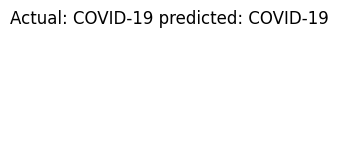

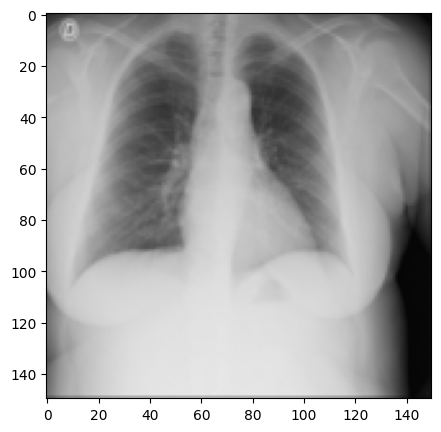

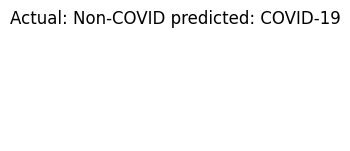

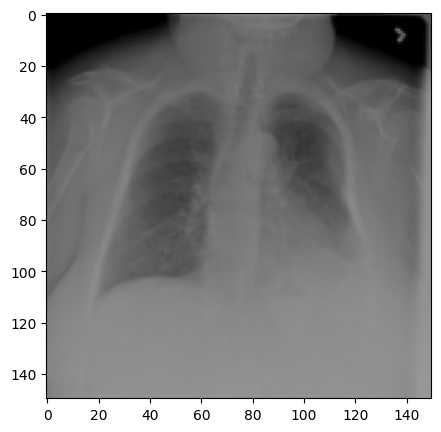

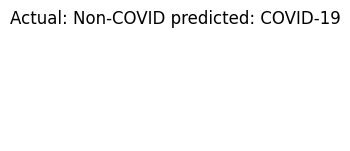

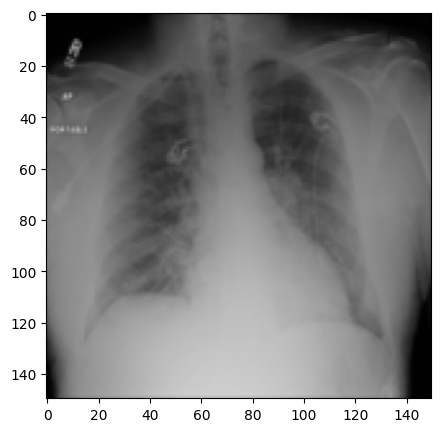

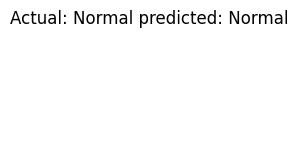

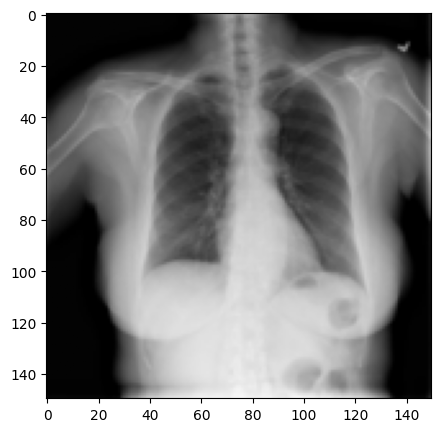

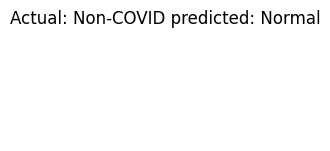

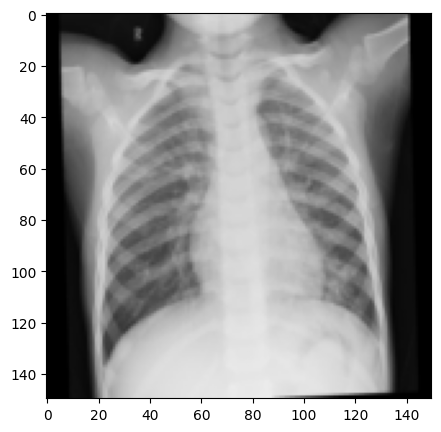

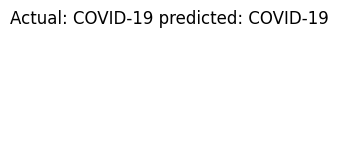

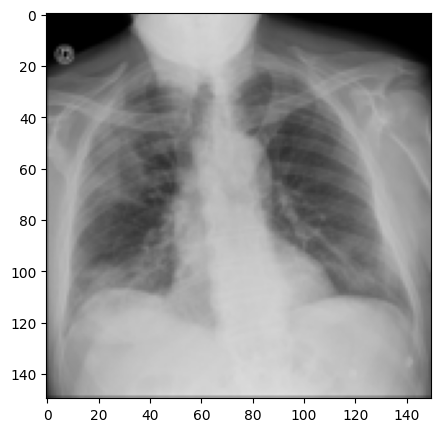

In [170]:
visualize_model(base_model)
plt.show()

3/6 es algo decente y honestamente sigo sin notar la diferencia personalmente lo cual lo vuelve mas difcil

## Evaluacion del modelo

In [ ]:
test_path = '/Users/jonathanvalencia/Downloads/m3ex02-data/Test'

In [172]:
covid_test = test_path + '/COVID-19'
normal_test = test_path + '/NORMAL'
noncovid_test = test_path + '/NON-COVID'

In [174]:
test_transforms = transforms.Compose([
                                      transforms.Resize((150,150)),
                                      transforms.ToTensor(),
                                      
])


test_image = datasets.ImageFolder(test_path, transform=test_transforms)

testloader = torch.utils.data.DataLoader(test_image, batch_size=1)

Importante no usar gradientes hacer la validacion con nuestros datos de Test

In [175]:
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for x_batch, y_batch in tqdm.tqdm(testloader, leave=False):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_test_pred = base_model(x_batch)
        y_test_pred = torch.log_softmax(y_test_pred, dim=1)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

  0%|          | 0/13576 [00:00<?, ?it/s]

In [176]:
y_pred_list = [i[0] for i in y_pred_list]
y_true_list = [i[0] for i in y_true_list]

matriz de scores:

In [177]:
print(classification_report(y_true_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.52      0.92      0.67      4790
           1       0.87      0.42      0.57      4506
           2       0.69      0.48      0.57      4280

    accuracy                           0.62     13576
   macro avg       0.70      0.61      0.60     13576
weighted avg       0.69      0.62      0.60     13576



In [178]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

Cree una matriz de confusion para poder evaluar el desempeño de mi modelo.

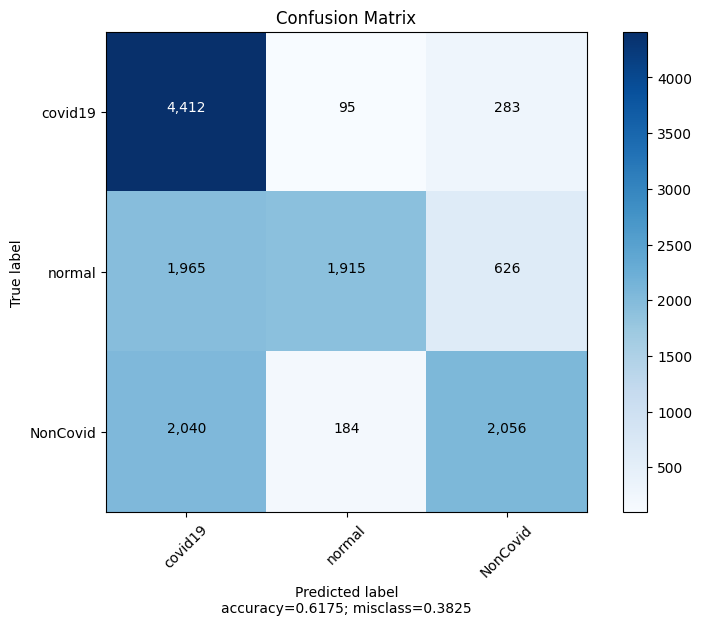

In [179]:
from sklearn.metrics import confusion_matrix

cm =  confusion_matrix(y_true_list, y_pred_list)

plot_confusion_matrix(cm = cm, 
                      normalize    = False,
                      target_names = ['covid19','normal', 'NonCovid'],
                      title        = "Confusion Matrix")

Finalmente guardo mi modelo:

In [180]:
torch.save(base_model.state_dict(), './best_model.pth')

Con esto concluye este examen. se puede observar que a pesar de tener un 62% de precision, cuando se trata de predecir Covid19 es cuando mejor se desempena el modelo. Sin duda hay mucho que mejorar, pero el tiempo me limita bastante en esta caso, podria comenzar por ampliar el numero de epocas, mejorar el data augmentation y hasta tomar una materia o 2 de medicina. Espero que este examen cumpla con las expectativas y cualquier feedback es bien recibido.